<a href="https://colab.research.google.com/github/hamidelahi/Quant-Finance/blob/main/MeanReverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#Yahoo finance to DL closing prices
!pip install yfinance
!pip install hurst

In [23]:
from google.colab import drive

# Try force remounting the drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [24]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 19.0 MB/s eta 0:00:00


In [27]:
import yfinance as yf
import numpy as np
from hurst import compute_Hc

# Download USD/CAD exchange rate data for the last 5 years
data = yf.download('CAD=X', start='2019-01-01', end='2024-01-01', interval='1d')

# Extract the 'Adj Close' column (adjusted closing prices)
y = data['Adj Close'].values

[*********************100%%**********************]  1 of 1 completed


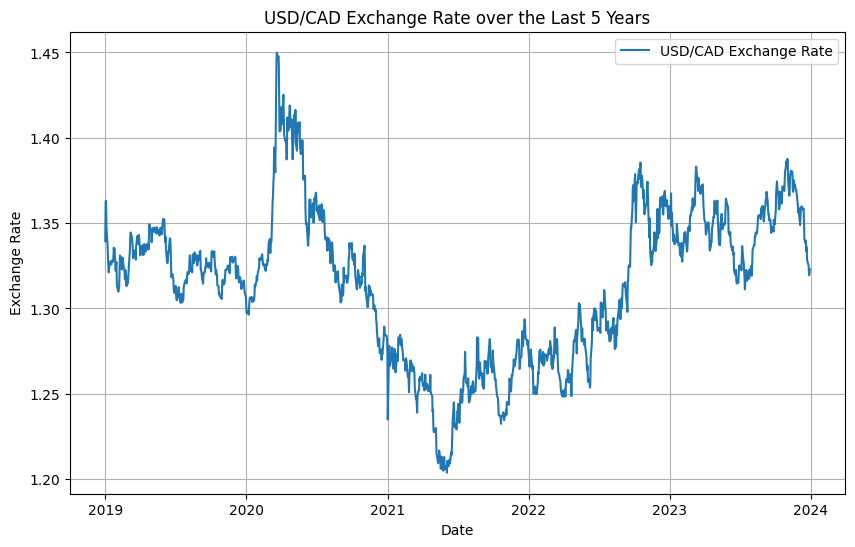

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(data.index, y, label='USD/CAD Exchange Rate')
plt.title('USD/CAD Exchange Rate over the Last 5 Years')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.legend()
plt.show()


In [29]:
import numpy as np
import statsmodels.tsa.stattools as ts

# Example time series data
y = data['Adj Close'].sort_index(ascending=True).values

# Perform the Augmented Dickey-Fuller test
# 'maxlag=0' corresponds to the MATLAB's '0' lag and 'regression="c"' corresponds to the constant (like MATLAB's '1')
results = ts.adfuller(y, maxlag=1, regression='c')

# Print the results
print('ADF Statistic:', results)

ADF Statistic: (-2.4081014473788787, 0.1394628789129983, 0, 1302, {'1%': -3.4353824418821852, '5%': -2.863762408248617, '10%': -2.567953223847985}, -9677.744305380182)


In [30]:
log_y = np.log(y)

# Calculate the Hurst exponent
H, c, data_reg = compute_Hc(log_y, kind='price', simplified=True)

# Print the Hurst exponent
print(f"Hurst exponent (H): {H}")

Hurst exponent (H): 0.5792404635038666


In [31]:
from arch.unitroot import VarianceRatio

vr_test = VarianceRatio(log_y, lags=2)
h = vr_test.stat
pValue = vr_test.pvalue

# Print the results
print(f"Variance Ratio Test Statistic (h): {h}")
print(f"P-Value: {pValue}")

Variance Ratio Test Statistic (h): -0.3638467605660421
P-Value: 0.7159724424563894


In [ ]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [ ]:
!git add .
!git commit -m "Your commit message"
!git push origin main

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git clone https://github.com//hamidelahi/Quant-Finance.git

Cloning into 'Quant-Finance'...


In [ ]:
!git config --global user.email "hamid.elahi@gmail.com"
!git config --global user.name "hamidelahi"

In [ ]:
!git add --all

error: '544/' does not have a commit checked out
fatal: adding files failed


In [33]:
import statsmodels.api as sm
ylag = np.roll(y, 1)

# Calculate the first difference (deltaY)
deltaY = y - ylag

# Remove the first value to handle NaN (which results from the lag operation)
deltaY = deltaY[1:]
ylag = ylag[1:]

# Run the OLS regression
X = sm.add_constant(ylag)  # Add a column of ones for the intercept term
model = sm.OLS(deltaY, X).fit()

# Calculate the half-life of mean reversion
halflife = -np.log(2) / model.params[1]

# Print the results
print("Half-life of mean reversion:", halflife)

Half-life of mean reversion: 78.99226682675648


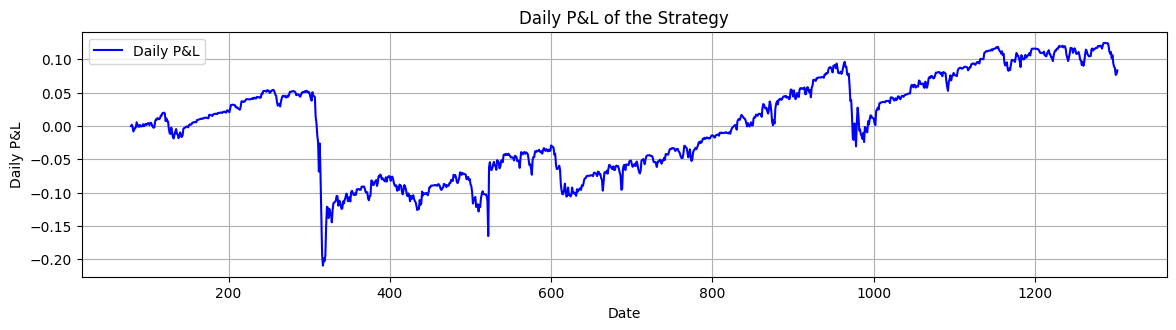

In [41]:
lookback = round(halflife)
y = data['Adj Close'].values
y = pd.Series(y)  # Convert directly to Series, removing the extra list

# Calculate moving average and moving standard deviation
moving_avg = y.rolling(window=lookback).mean()
moving_std = y.rolling(window=lookback).std()


# Calculate market value signals (mktVal)
mktVal = -(y - moving_avg) / moving_std

# Calculate lagged values
mktVal_lag = mktVal.shift(1)
y_lag = y.shift(1)
y_diff = y - y_lag

# Calculate daily P&L
pnl = mktVal_lag * y_diff / y_lag

# Calculate cumulative P&L
cumulative_pnl = pnl.cumsum()

# Plot the daily P&L and cumulative P&L
plt.figure(figsize=(14, 7))

# Plot daily P&L
plt.subplot(2, 1, 1)
plt.plot(cumulative_pnl, label='Daily P&L', color='blue')
plt.title('Daily P&L of the Strategy')
plt.xlabel('Date')
plt.ylabel('Daily P&L')
plt.legend()
plt.grid(True)

In [38]:
y

,0
0,"[1.3394299745559692, 1.3625400066375732, 1.363..."
